# Google Play Store Apps
### Web scraped data of 10k Play Store apps for analysing the Android market.

L'objectiu d'aquest treball és determinar a quines aplicacions de la Google Play Store són més rentables i quins atributs fan que es descarreguin més. El [dataset](https://www.kaggle.com/datasets/lava18/google-play-store-apps) que hem fet servir conté un total de 10841 aplicacions de Google Play Store i de cadascuna s'especifica uns atributs:
 * **App**: Nom de l'aplicació, tipus String.
 * **Category**: Categoria de l'aplicació, tipus String.
 * **Rating**: Nota mitjana posada pels usuaris, tipus Float entre 0 i 5.
 * **Reviews**: Nombre de comentraris dels usuaris sobre l'app, tipus Integer.
 * **Size**: Pes de l'aplicació, tipus String.
 * **Installs**: Nombre de descàrregues de l'aplicació, tipus String.
 * **Type**: Aplicació gratuita o de pagament, tipus String.
 * **Price**: Preu de l'aplicació, tipus Float.
 * **Content Rating**: Categoria de gent a la que va dirigida l'app, tipus String. (Adolescents, nens, adults...)
 * **Genres**: Gèneres als que pertany l'aplicació, tipus String.
 * **Last updated**: Última vegada que es va llançar una actualització, tipus String.
 * **Current ver**: Versió actual de l'aplicació, tipus String.
 * **Android ver**: Versió mínima requerida del SO Android per poder-la instal·lar, tipus String.

 Volem saber quines característiques són les més importants a l'hora de determinar quina app es descarrega més per poder rentabilitzar l'aplicació.

# Imports de llibreries necessàries

In [276]:
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn import preprocessing
from sklearn.compose import make_column_transformer
from sklearn.datasets import make_regression
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics

import math
import numpy as np
import pandas as pd
import random
import seaborn as sns
import scipy.stats
import warnings

In [277]:
warnings.filterwarnings("ignore", category=FutureWarning)

# Càrrega del dataset

In [278]:
dataset = pd.read_csv('./googleplaystore.csv', header=0, delimiter=',')

print("Dimensions de la base de dades:", dataset.shape)

Dimensions de la base de dades: (10841, 13)


# Exploratory Data Analysis

Abans de res, primer cal que analitzem com és el dataset, quins atributs té, quins tipus de dades conté, si conté duplicats, etc... És per això que primer en farem un anàlisi preliminar per descobrir com està organitzat.

Mostrem les primeres files per veure com són:

In [279]:
dataset.head(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


Seguidament, analitzem quin tipus de dades conté:

In [280]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


Veiem que la majoria de dades són de tipus 'object' i això implica que haurem d'adaptar-lo per poder treballar-hi i fer-hi un estudi. 
La informació ens indica que el dataset conté un total de 10841 aplicacions, però cal veure si algunes d'aquestes són duplicades.

In [281]:
dataset['App'].nunique()

9660

Comprovem que, efectivament existeixen aplicacions duplicades i que d'úniques només n'existeixen 9660.

Seguidament, procedim a analitzar cadascun dels atributs i quins són els valors possibles que poden prendre:

Comencem amb l'atribut "**Categories**":

In [282]:
print(dataset['Category'].unique())
print(dataset['Category'].nunique())

['ART_AND_DESIGN' 'AUTO_AND_VEHICLES' 'BEAUTY' 'BOOKS_AND_REFERENCE'
 'BUSINESS' 'COMICS' 'COMMUNICATION' 'DATING' 'EDUCATION' 'ENTERTAINMENT'
 'EVENTS' 'FINANCE' 'FOOD_AND_DRINK' 'HEALTH_AND_FITNESS' 'HOUSE_AND_HOME'
 'LIBRARIES_AND_DEMO' 'LIFESTYLE' 'GAME' 'FAMILY' 'MEDICAL' 'SOCIAL'
 'SHOPPING' 'PHOTOGRAPHY' 'SPORTS' 'TRAVEL_AND_LOCAL' 'TOOLS'
 'PERSONALIZATION' 'PRODUCTIVITY' 'PARENTING' 'WEATHER' 'VIDEO_PLAYERS'
 'NEWS_AND_MAGAZINES' 'MAPS_AND_NAVIGATION' '1.9']
34


Observem que existeix un total de 34 categories diferents i que són totes String.

Seguidament, analitzem els valors que existeixen a la columna "**Rating**":

In [283]:
print(dataset['Rating'].unique())
print(dataset['Rating'].nunique())

[ 4.1  3.9  4.7  4.5  4.3  4.4  3.8  4.2  4.6  3.2  4.   nan  4.8  4.9
  3.6  3.7  3.3  3.4  3.5  3.1  5.   2.6  3.   1.9  2.5  2.8  2.7  1.
  2.9  2.3  2.2  1.7  2.   1.8  2.4  1.6  2.1  1.4  1.5  1.2 19. ]
40


Observem que existeix un total de 40 notes diferents.

Procedim després a analitzar també quines dades tenim a la columna "**Reviews**":

In [284]:
print(dataset['Reviews'].nunique())

for i, j in enumerate(dataset['Reviews']):
    try:
        j = float(j)
    except ValueError:
        print([i], j)

6002
[10472] 3.0M


Observem que tenim 6002 nombres de reviews diferents i provem de passar-los a float. Funciona en tots els valors excepte el de la fila 10472 perquè sembla que han afegit una dada a una posició errònia. La tractarem forçant-la a un valor NaN perquè no sabem quin valor li tocaria.

In [285]:
dataset['Reviews'][10472] = None
print(dataset['Reviews'].unique())

['159' '967' '87510' ... '603' '1195' '398307']


C:\Users\Beri\AppData\Local\Temp\ipykernel_15720\1987135936.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Reviews'][10472] = None


Posteriorment realitzem la mateixa exploració amb la columna "**Size**":

In [286]:
print(dataset['Size'].unique())
print(dataset['Size'].nunique())

['19M' '14M' '8.7M' '25M' '2.8M' '5.6M' '29M' '33M' '3.1M' '28M' '12M'
 '20M' '21M' '37M' '2.7M' '5.5M' '17M' '39M' '31M' '4.2M' '7.0M' '23M'
 '6.0M' '6.1M' '4.6M' '9.2M' '5.2M' '11M' '24M' 'Varies with device'
 '9.4M' '15M' '10M' '1.2M' '26M' '8.0M' '7.9M' '56M' '57M' '35M' '54M'
 '201k' '3.6M' '5.7M' '8.6M' '2.4M' '27M' '2.5M' '16M' '3.4M' '8.9M'
 '3.9M' '2.9M' '38M' '32M' '5.4M' '18M' '1.1M' '2.2M' '4.5M' '9.8M' '52M'
 '9.0M' '6.7M' '30M' '2.6M' '7.1M' '3.7M' '22M' '7.4M' '6.4M' '3.2M'
 '8.2M' '9.9M' '4.9M' '9.5M' '5.0M' '5.9M' '13M' '73M' '6.8M' '3.5M'
 '4.0M' '2.3M' '7.2M' '2.1M' '42M' '7.3M' '9.1M' '55M' '23k' '6.5M' '1.5M'
 '7.5M' '51M' '41M' '48M' '8.5M' '46M' '8.3M' '4.3M' '4.7M' '3.3M' '40M'
 '7.8M' '8.8M' '6.6M' '5.1M' '61M' '66M' '79k' '8.4M' '118k' '44M' '695k'
 '1.6M' '6.2M' '18k' '53M' '1.4M' '3.0M' '5.8M' '3.8M' '9.6M' '45M' '63M'
 '49M' '77M' '4.4M' '4.8M' '70M' '6.9M' '9.3M' '10.0M' '8.1M' '36M' '84M'
 '97M' '2.0M' '1.9M' '1.8M' '5.3M' '47M' '556k' '526k' '76M' '7.6M'

Observem que a la columna "**Size**" les dades tenen un caràcter de més que indica la magnitud del seu pes. Veiem també que existeix una fila amb el valor '1000+' i caldrà que després el tractem per poder realitzar correctament l'estudi.

Fem el mateix amb la següent columna, la columna "**Installs**":

In [287]:
print(dataset['Installs'].unique())
print(dataset['Installs'].nunique())

['10,000+' '500,000+' '5,000,000+' '50,000,000+' '100,000+' '50,000+'
 '1,000,000+' '10,000,000+' '5,000+' '100,000,000+' '1,000,000,000+'
 '1,000+' '500,000,000+' '50+' '100+' '500+' '10+' '1+' '5+' '0+' '0'
 'Free']
22


Detectem un altre cop que tornen a haver-hi dades mal col·locades i algunes que representen el mateix però en diferent format i provoca que s'interpretin com a diferents.

Realitzem el mateix procediment amb la columna "**Type**":

In [288]:
print(dataset['Type'].unique())
print(dataset['Type'].nunique())

['Free' 'Paid' nan '0']
3


Observem que tornem a tenir dades mal col·locades com és el cas del zero, tot i que podem entendre-ho com que és gratuïta. Aquesta columna al només contenir dos possibles valors, la podrem transformar en un valor booleà.

Comprovem quins valors pot prendre la columna "**Price**":

In [289]:
print(dataset['Price'].unique())
print(dataset['Price'].nunique())

['0' '$4.99' '$3.99' '$6.99' '$1.49' '$2.99' '$7.99' '$5.99' '$3.49'
 '$1.99' '$9.99' '$7.49' '$0.99' '$9.00' '$5.49' '$10.00' '$24.99'
 '$11.99' '$79.99' '$16.99' '$14.99' '$1.00' '$29.99' '$12.99' '$2.49'
 '$10.99' '$1.50' '$19.99' '$15.99' '$33.99' '$74.99' '$39.99' '$3.95'
 '$4.49' '$1.70' '$8.99' '$2.00' '$3.88' '$25.99' '$399.99' '$17.99'
 '$400.00' '$3.02' '$1.76' '$4.84' '$4.77' '$1.61' '$2.50' '$1.59' '$6.49'
 '$1.29' '$5.00' '$13.99' '$299.99' '$379.99' '$37.99' '$18.99' '$389.99'
 '$19.90' '$8.49' '$1.75' '$14.00' '$4.85' '$46.99' '$109.99' '$154.99'
 '$3.08' '$2.59' '$4.80' '$1.96' '$19.40' '$3.90' '$4.59' '$15.46' '$3.04'
 '$4.29' '$2.60' '$3.28' '$4.60' '$28.99' '$2.95' '$2.90' '$1.97'
 '$200.00' '$89.99' '$2.56' '$30.99' '$3.61' '$394.99' '$1.26' 'Everyone'
 '$1.20' '$1.04']
93


En aquest cas, el primer que salta a la vista és la utilització del símbol de dòlar ($) que caldrà eliminar per poder transformar els valors a numèrics posteriorment.
També observem que s'ha colat un valor 'Everyone' que està mal col·locat i el substituim per NaN perquè no sabem quin preu hauria d'anar-hi.

In [290]:
dataset['Price'][dataset['Price'] == 'Everyone'] = None

C:\Users\Beri\AppData\Local\Temp\ipykernel_15720\3896408669.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Price'][dataset['Price'] == 'Everyone'] = None


Estudiem el contingut de la columna "**Content Rating**" doncs també ens pot ser útil per a l'estudi:

In [291]:
print(dataset['Content Rating'].unique())
print(dataset['Content Rating'].nunique())

['Everyone' 'Teen' 'Everyone 10+' 'Mature 17+' 'Adults only 18+' 'Unrated'
 nan]
6


Observem que existeixen 6 tipus de categories diferents i que, evidentment, el preu anterior que contenia 'Everyone' era equivocat i pertanyia a aquesta categoria.

Finalment estudiem el contingut de la columna "**Genres**", que conté moltes etiquetes i considerem que el gènere deu ser un factor important a tenir en compte:

In [292]:
print(dataset['Genres'].unique())
print(dataset['Genres'].nunique())

['Art & Design' 'Art & Design;Pretend Play' 'Art & Design;Creativity'
 'Art & Design;Action & Adventure' 'Auto & Vehicles' 'Beauty'
 'Books & Reference' 'Business' 'Comics' 'Comics;Creativity'
 'Communication' 'Dating' 'Education;Education' 'Education'
 'Education;Creativity' 'Education;Music & Video'
 'Education;Action & Adventure' 'Education;Pretend Play'
 'Education;Brain Games' 'Entertainment' 'Entertainment;Music & Video'
 'Entertainment;Brain Games' 'Entertainment;Creativity' 'Events' 'Finance'
 'Food & Drink' 'Health & Fitness' 'House & Home' 'Libraries & Demo'
 'Lifestyle' 'Lifestyle;Pretend Play' 'Adventure;Action & Adventure'
 'Arcade' 'Casual' 'Card' 'Casual;Pretend Play' 'Action' 'Strategy'
 'Puzzle' 'Sports' 'Music' 'Word' 'Racing' 'Casual;Creativity'
 'Casual;Action & Adventure' 'Simulation' 'Adventure' 'Board' 'Trivia'
 'Role Playing' 'Simulation;Education' 'Action;Action & Adventure'
 'Casual;Brain Games' 'Simulation;Action & Adventure'
 'Educational;Creativity' 'Puzzle

En aquest cas veiem com existeixen 120 generes diferents però que molts d'aquests estan ajuntats amb altres gèneres, ja que una aplicació, igual que una película, pot pertànyer a més d'un gènere diferent.

Considerarem que la resta de columnes del dataset no són tan rellevants i per tant no les emprarem en aquest estudi.

# Dataset preprocessing

Un cop analitzat el dataset i entès quines dades conté, com funcionen i què representen, el següent pas que realitzarem és el de netejar-lo. Necessitem netejar-lo perquè com hem vist, conté dades que no ens són útils, com valors NaNs, valors en columnes errònies, etc...

El primer pas que realitzarem és eliminar totes les columnes duplicades

In [293]:
dataset.drop_duplicates(['App','Size','Installs','Reviews','Rating','Price','Android Ver'], inplace=True)

Seguidament, mirem la quantitat de valors nans que existeixen per columna i eliminarem les files que en continguin.

In [294]:
dataset.isnull().sum()

App                  0
Category             0
Rating            1465
Reviews              1
Size                 0
Installs             0
Type                 1
Price                1
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

In [295]:
dataset = dataset.dropna()

In [296]:
dataset.isnull().sum()

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       0
Android Ver       0
dtype: int64

Un cop trets els NaNs, tractem els signes positius de la columna "**Installs**" i també el caràcter ','.

In [297]:
dataset['Installs'] = dataset['Installs'].str.replace("+", "")
dataset['Installs'] = dataset['Installs'].str.replace(",", "")

Llavors, traiem el signe $ de la columna "**Price**".

In [298]:
dataset['Price']= dataset["Price"].str.replace("$", "")

Finalment, havíem vist que amb la columna "**Size**" havíem de treure les lletres K i M, i els valors que diu que varia segons dispositiu, els representarem amb un -1. També cal fer les operacions necessàries per transformar-ho tot a les mateixes unitats, que en aquest cas farem servir Megues (M).

In [299]:
dataset['Size'] = dataset["Size"].str.replace("M", "")
dataset['Size'] = dataset['Size'].str.replace("Varies with device","-1")

In [300]:
dataset['Size'] = dataset['Size'].apply(lambda x: str(round((float(x.rstrip('k'))/1024),1) )if x[-1]=='k' else x)

Un cop transformades les dades, només cal passar-les a dades numèriques en comptes de Strings.

In [301]:
dataset['Reviews'] = dataset['Reviews'].astype(float)
dataset['Size'] = dataset['Size'].astype(float)
dataset['Installs'] = dataset['Installs'].astype(float)
dataset['Price'] = dataset['Price'].astype(float)

Com que el dataset a la columna "**Genre**" conté gèneres conformats per més d'un gènere, en farem servir el gènere principal només, eliminant-ne la resta.

In [302]:
print(dataset['Genres'].nunique())
dataset['Genres'] = dataset['Genres'].str.split(';').str[0]
print(dataset['Genres'].nunique())
print(dataset['Genres'].unique())

115
48
['Art & Design' 'Auto & Vehicles' 'Beauty' 'Books & Reference' 'Business'
 'Comics' 'Communication' 'Dating' 'Education' 'Entertainment' 'Events'
 'Finance' 'Food & Drink' 'Health & Fitness' 'House & Home'
 'Libraries & Demo' 'Lifestyle' 'Adventure' 'Arcade' 'Casual' 'Card'
 'Action' 'Strategy' 'Puzzle' 'Sports' 'Music' 'Word' 'Racing'
 'Simulation' 'Board' 'Trivia' 'Role Playing' 'Educational'
 'Music & Audio' 'Video Players & Editors' 'Medical' 'Social' 'Shopping'
 'Photography' 'Travel & Local' 'Tools' 'Personalization' 'Productivity'
 'Parenting' 'Weather' 'News & Magazines' 'Maps & Navigation' 'Casino']


Observem que existeixen dos gèneres que podem considerar equivalents, ("Music" i "Music & Audio"), així que les modificarem per unificar-les en un sol gènere "Music".

In [303]:
dataset['Genres'].replace('Music & Audio', 'Music', inplace=True)

Finalment, com que la columna "**Last Updated**" conté la data en que es van actualitzar per últim cop. Està en format string, però simbolitza un dia, pel que cal que transformem el format a un format comprensible per l'anàlisi de dades. El transformarem a un nombre que representi la diferència entre la data més actual del dataset i la data de la fila en concret.

In [304]:
dataset['aux'] = pd.to_datetime(dataset['Last Updated'])
dataset['Last Updated'] = (dataset['aux'].max() - dataset['aux']).dt.days
dataset.drop(['aux'], axis=1, inplace=True)

Ara que hem realitzat les transformacions adients, podem veure quina és la correlació entre les dades.

# Correlació entre dades

El primer que volem fer és calcular la correlació entre les dades i la seva distribució. El primer que farem és veure la proporció entre aplicacions gratuïtes i de pagament.

Type
Free    8268
Paid     610
Name: count, dtype: int64


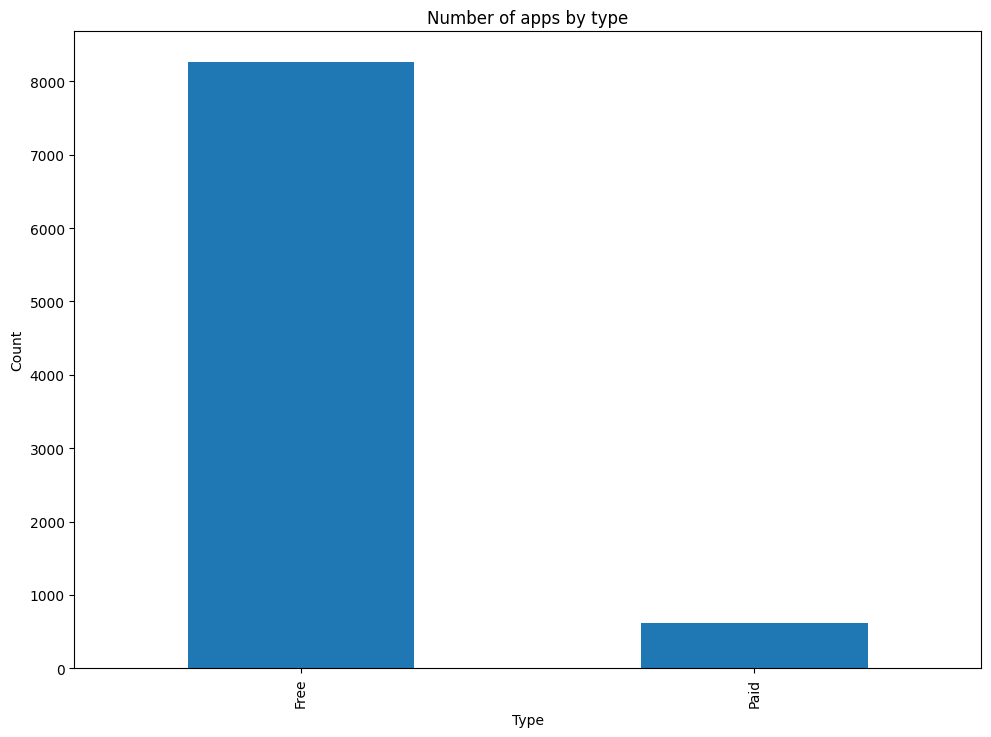

In [305]:
print(dataset['Type'].value_counts())

dataset['Type'].value_counts().plot.bar()
plt.ylabel("Count")
plt.xlabel("Type")
plt.title("Number of apps by type")

plt.show()

Observem que hi ha moltíssimes més aplicacions gratuïtes que no pas de pagament.

Com que abans hem aplicat les transformacions necessàries per poder interpretar les dades, fem un heatmap per veure com de relacionades estan les dades entre si.

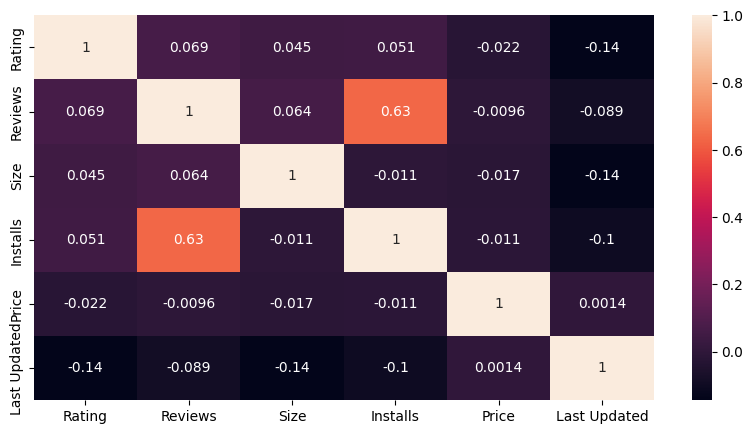

In [306]:
numeric_cols = dataset.select_dtypes(include=[np.number])

corr = numeric_cols.corr()

plt.figure(figsize=(10, 5))
sns.heatmap(corr, annot=True)
plt.show()

Amb el mapa de calor veiem clarament que les úniques columnes relacionades són les de "**Installs**" i "**Reviews**", és a dir que com més descàrregues tingui una aplicació més comentaris rep.

# Aplicacions més descarregades

És interessant saber quines aplicacions són les més descarregades, quina categoria ocupen i quina valoració tenen.

Imprimim les més descarregades per categories.

In [307]:
dataset.groupby("Category").Installs.agg(["min", "mean", "median", "max"])

,min,mean,median,max
Category,,,,
ART_AND_DESIGN,100.0,2.036526e+06,100000.0,5.000000e+07
AUTO_AND_VEHICLES,100.0,7.278055e+05,100000.0,1.000000e+07
BEAUTY,100.0,6.408619e+05,100000.0,1.000000e+07
BOOKS_AND_REFERENCE,5.0,1.082651e+07,100000.0,1.000000e+09
BUSINESS,5.0,3.198215e+06,10000.0,1.000000e+08
COMICS,100.0,9.661397e+05,100000.0,1.000000e+07
COMMUNICATION,10.0,7.867180e+07,1000000.0,1.000000e+09
DATING,10.0,1.298883e+06,100000.0,1.000000e+07
EDUCATION,1000.0,4.138388e+06,1000000.0,1.000000e+08


N'ordenem el conjunt segons el major nombre de descarregues:

In [308]:
top_apps = dataset.sort_values(by="Installs", ascending=False).head()
top_apps.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
386,Hangouts,COMMUNICATION,4.0,3419433.0,-1.0,1.000000e+09,Free,0.0,Everyone,Communication,18,Varies with device,Varies with device
3736,Google News,NEWS_AND_MAGAZINES,3.9,877635.0,13.0,1.000000e+09,Free,0.0,Teen,News & Magazines,7,5.2.0,4.4 and up
4098,Maps - Navigate & Explore,TRAVEL_AND_LOCAL,4.3,9231613.0,-1.0,1.000000e+09,Free,0.0,Everyone,Travel & Local,8,Varies with device,Varies with device
3909,Instagram,SOCIAL,4.5,66509917.0,-1.0,1.000000e+09,Free,0.0,Teen,Social,8,Varies with device,Varies with device
2604,Instagram,SOCIAL,4.5,66577446.0,-1.0,1.000000e+09,Free,0.0,Teen,Social,8,Varies with device,Varies with device


No podem saber quina és la més descarregada perquè n'hi ha moltes que comparteixen tenir més d'un bilió de descarregues.

In [309]:
print("Nombre d'apps amb +1B descarregues: ", len(dataset[dataset["Installs"]>= 1000000000]))

Nombre d'apps amb +1B descarregues:  49


Procedim llavors a veure quines són les aplicacions més descarregades i amb millor valoració:

In [310]:
top_installed_rated = dataset.sort_values(by=["Installs", "Rating"], ascending=False)
top_installed_rated.head(10)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
1654,Subway Surfers,GAME,4.5,27722264.0,76.0,1.000000e+09,Free,0.0,Everyone 10+,Arcade,27,1.90.0,4.1 and up
1700,Subway Surfers,GAME,4.5,27723193.0,76.0,1.000000e+09,Free,0.0,Everyone 10+,Arcade,27,1.90.0,4.1 and up
1750,Subway Surfers,GAME,4.5,27724094.0,76.0,1.000000e+09,Free,0.0,Everyone 10+,Arcade,27,1.90.0,4.1 and up
1872,Subway Surfers,GAME,4.5,27725352.0,76.0,1.000000e+09,Free,0.0,Everyone 10+,Arcade,27,1.90.0,4.1 and up
2545,Instagram,SOCIAL,4.5,66577313.0,-1.0,1.000000e+09,Free,0.0,Teen,Social,8,Varies with device,Varies with device
2604,Instagram,SOCIAL,4.5,66577446.0,-1.0,1.000000e+09,Free,0.0,Teen,Social,8,Varies with device,Varies with device
2808,Google Photos,PHOTOGRAPHY,4.5,10858556.0,-1.0,1.000000e+09,Free,0.0,Everyone,Photography,2,Varies with device,Varies with device
2853,Google Photos,PHOTOGRAPHY,4.5,10858538.0,-1.0,1.000000e+09,Free,0.0,Everyone,Photography,2,Varies with device,Varies with device
2884,Google Photos,PHOTOGRAPHY,4.5,10859051.0,-1.0,1.000000e+09,Free,0.0,Everyone,Photography,2,Varies with device,Varies with device
3896,Subway Surfers,GAME,4.5,27711703.0,76.0,1.000000e+09,Free,0.0,Everyone 10+,Arcade,27,1.90.0,4.1 and up


Veiem que en funció de les descàrregues i valoració mitjana les millors són Subway Surfers, Instagram i Google Photos.

Procedim també a veure quines són les més descarregades i que tenen més comentaris també:

In [311]:
top_installed_reviewed = dataset.sort_values(by=["Installs", "Reviews"], ascending=False)
top_installed_reviewed.head(10)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
2544,Facebook,SOCIAL,4.1,78158306.0,-1.0,1.000000e+09,Free,0.0,Teen,Social,5,Varies with device,Varies with device
3943,Facebook,SOCIAL,4.1,78128208.0,-1.0,1.000000e+09,Free,0.0,Teen,Social,5,Varies with device,Varies with device
336,WhatsApp Messenger,COMMUNICATION,4.4,69119316.0,-1.0,1.000000e+09,Free,0.0,Everyone,Communication,5,Varies with device,Varies with device
3904,WhatsApp Messenger,COMMUNICATION,4.4,69109672.0,-1.0,1.000000e+09,Free,0.0,Everyone,Communication,5,Varies with device,Varies with device
2604,Instagram,SOCIAL,4.5,66577446.0,-1.0,1.000000e+09,Free,0.0,Teen,Social,8,Varies with device,Varies with device
2545,Instagram,SOCIAL,4.5,66577313.0,-1.0,1.000000e+09,Free,0.0,Teen,Social,8,Varies with device,Varies with device
3909,Instagram,SOCIAL,4.5,66509917.0,-1.0,1.000000e+09,Free,0.0,Teen,Social,8,Varies with device,Varies with device
382,Messenger – Text and Video Chat for Free,COMMUNICATION,4.0,56646578.0,-1.0,1.000000e+09,Free,0.0,Everyone,Communication,7,Varies with device,Varies with device
335,Messenger – Text and Video Chat for Free,COMMUNICATION,4.0,56642847.0,-1.0,1.000000e+09,Free,0.0,Everyone,Communication,7,Varies with device,Varies with device
1872,Subway Surfers,GAME,4.5,27725352.0,76.0,1.000000e+09,Free,0.0,Everyone 10+,Arcade,27,1.90.0,4.1 and up


Veiem doncs que en funció de les descàrregues, les millors són Facebook, WhatsApp, Instagram, Messenger i Subway Surfers.

Podríem dir doncs que les més descarregades en general són Instagram i Subway Surfers doncs apareixen a ambdós tops.

# Franja d'edat amb més aplicacions

També pot ser interessant descobrir quina és la franja d'edat amb més aplicacions, que a la base de dades es representa amb la columna "**Content Rating**".
Aquesta columna s'ha d'estudiar sola perquè no podem transformar-los a valors numèrics.

Primer mirem el nombre de categories que hi han i les seves etiquetes:

In [312]:
print(dataset['Content Rating'].value_counts(ascending=False))
print(dataset['Content Rating'].nunique())

Content Rating
Everyone           7083
Teen               1021
Mature 17+          411
Everyone 10+        359
Adults only 18+       3
Unrated               1
Name: count, dtype: int64
6


Aquestes dades, transformades en un gràfic per veure-ho millor es veuen de la següent manera:

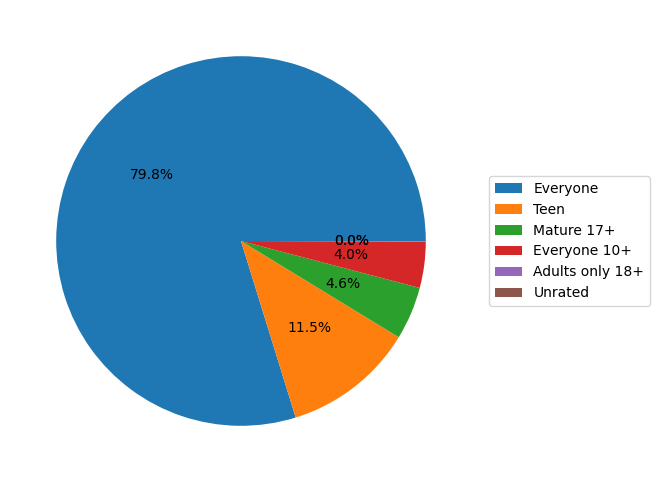

In [313]:
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))

num_apps = dataset["Content Rating"].value_counts()

labels = num_apps.index

sizes = num_apps.values

ax.pie(sizes,labeldistance=2,autopct='%1.1f%%')
ax.legend(labels=labels,loc="right",bbox_to_anchor=(0.9, 0, 0.5, 1))

Veiem així doncs, que la gran majoria de les aplicacions entren a la categoria Everyone, amb gairebé un 80% i que la següent és Teen amb un 11.5%.

# Categories amb més aplicacions de pagament

És interessant també saber quines categories són les que solen tenir aplicacions de pagament i quins preus posen, doncs creiem per sentit comú que aplicacions més complexes i/o específiques és probable que costin més diners. Visualitzem-ho:

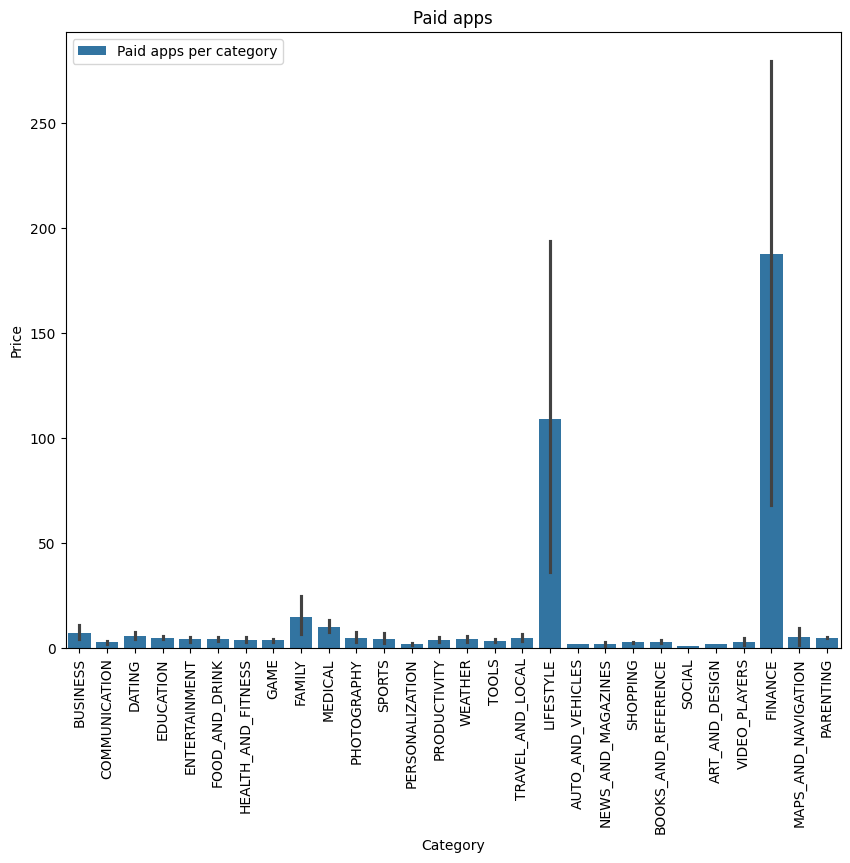

In [314]:
apps_pagament = dataset[dataset["Price"] != 0.0]

pagament_family = apps_pagament[apps_pagament["Category"]=="FAMILY"]
pagament_family.count()

pagament_communication = apps_pagament[apps_pagament["Category"]=="COMMUNICATION"]
pagament_communication.count()

plt.figure(figsize=(10,8))
sns.barplot(x="Category", y="Price", data=apps_pagament,
            label="Paid apps per category")
plt.title("Paid apps")
plt.xticks(rotation=90)
plt.show()

Observem clarament que les aplicacions relacionades amb finances i diners solen ser més de pagament que gratuïtes, en canvi, la majoria de la resta d'aplicacions excepte les de Lifestyle, solen ser gratuïtes.

# Com obtenir una bona valoració

Tenim la lleugera sospita que el que fa que es descarreguin més les aplicacions és la seva valoració, és a dir que si és bona, obtindrem més descàrregues. És per això que intentarem entendre què és el que hem de fer per obtenir una bona valoració.

Text(0.5, 1.0, 'Distribution of Rating')

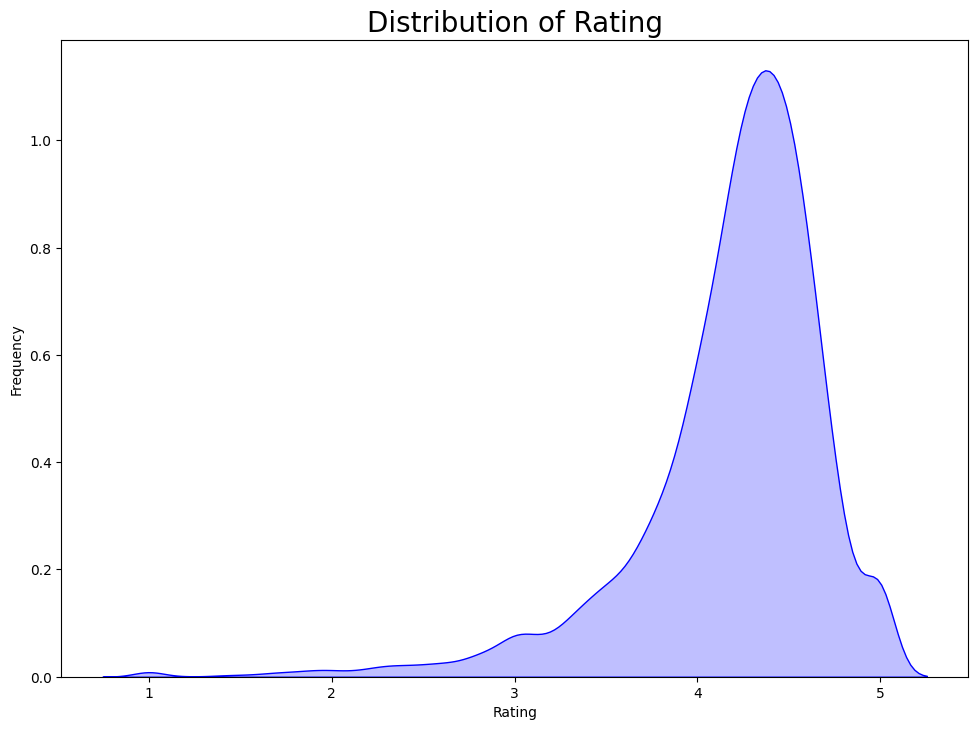

In [315]:
rcParams['figure.figsize'] = 11.7,8.27
g = sns.kdeplot(dataset['Rating'], color="Blue", shade = True)
g.set_xlabel("Rating")
g.set_ylabel("Frequency")
plt.title('Distribution of Rating',size = 20)

Observem la distribució de la variable rating i com la majoria d'aplicacions tenen una valoració d'entre 4 i 5 estrelles.

El que volem fer és una comparativa entre la columna "**Rating**" i altres columnes per veure si algunes tenen relació. No ho farem amb la columna "**Type**" que indica si és gratuïta o de pagament perquè com hem vist abans, la distribució de les mostres és molt desigual a favor de les gratuïtes.

Comencem amb la columna "**Reviews**":

<Figure size 1000x1000 with 0 Axes>

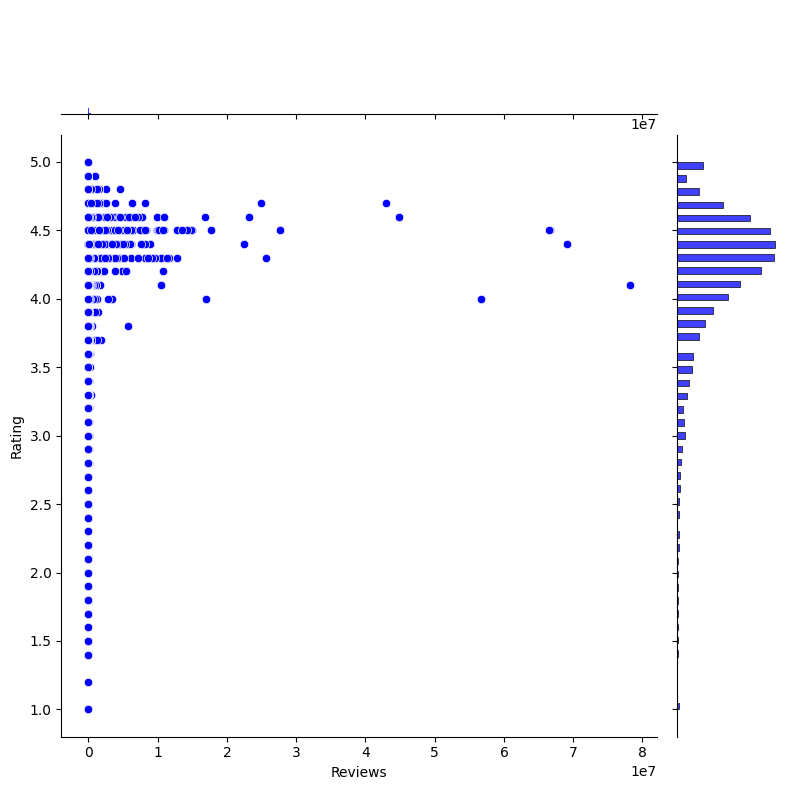

In [316]:
plt.figure(figsize = (10,10))
g = sns.jointplot(x="Reviews", y="Rating", color = 'blue', data = dataset, height = 8)

Observem com les aplicacions amb valoració més alta també són les que més reviews tenen. Podem mirar de representar aquesta tendència a través d'una regressió lineal:

Text(0.5, 1.0, 'Rating vs Reviews')

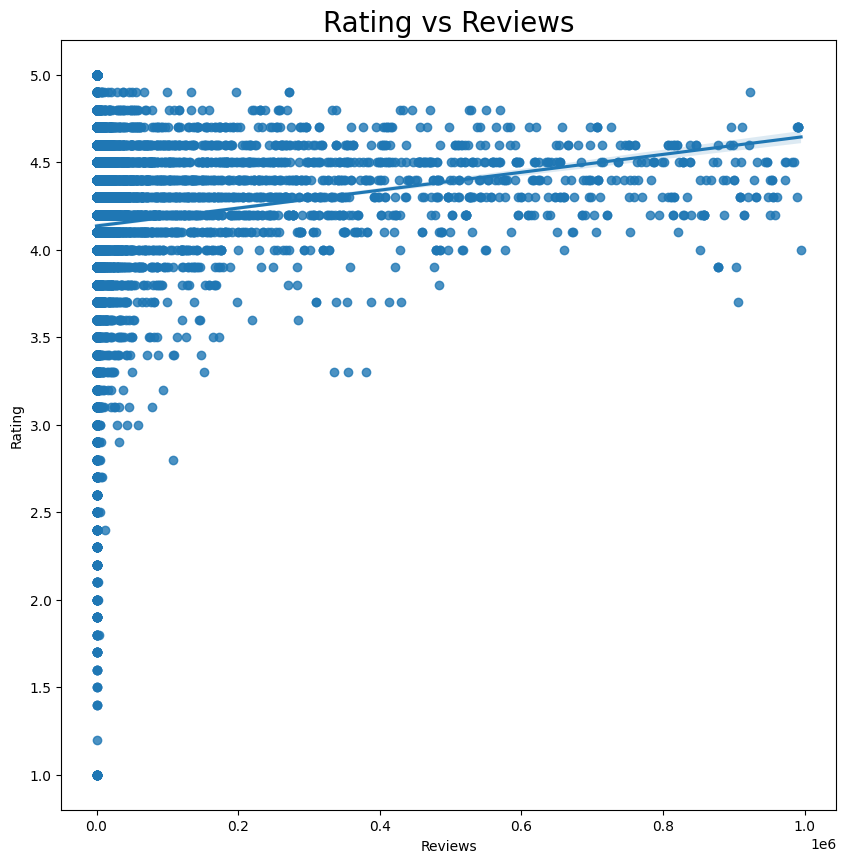

In [317]:
plt.figure(figsize = (10,10))
sns.regplot(x="Reviews", y="Rating", data=dataset[dataset['Reviews']<1000000]); #poso aquesta condició per encuadrar millor les dades en el gràfic
plt.title('Rating vs Reviews',size = 20)

Aplicant una regressió lineal amb Seaborn veiem que, efectivament, estan relacionades.

Procedim a fer-ho amb la columna "**Size**" de la mateixa manera:

<Figure size 1000x1000 with 0 Axes>

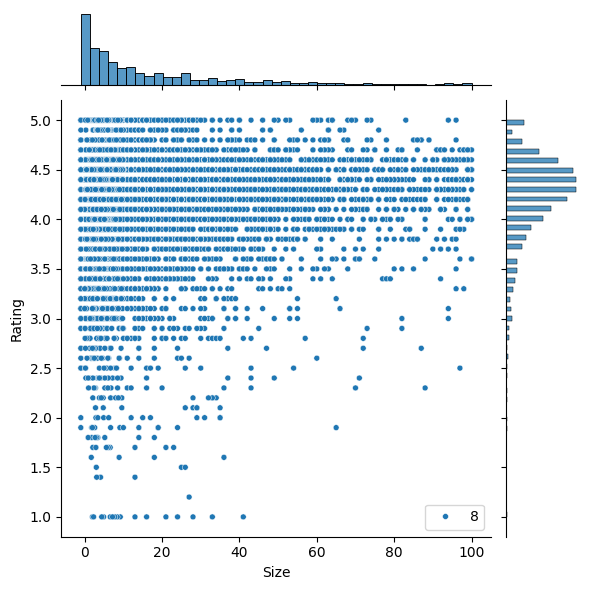

In [318]:
plt.figure(figsize = (10,10))
sns.jointplot(x="Size", y="Rating", data=dataset, size = 8)

Observem també que la relació entre el pes de l'aplicació i la seva valoració també existeix, però en menor mesura. Tornem a aplicar regressió lineal per visualitzar-ho millor:

Text(0.5, 1.0, 'Rating vs Size')

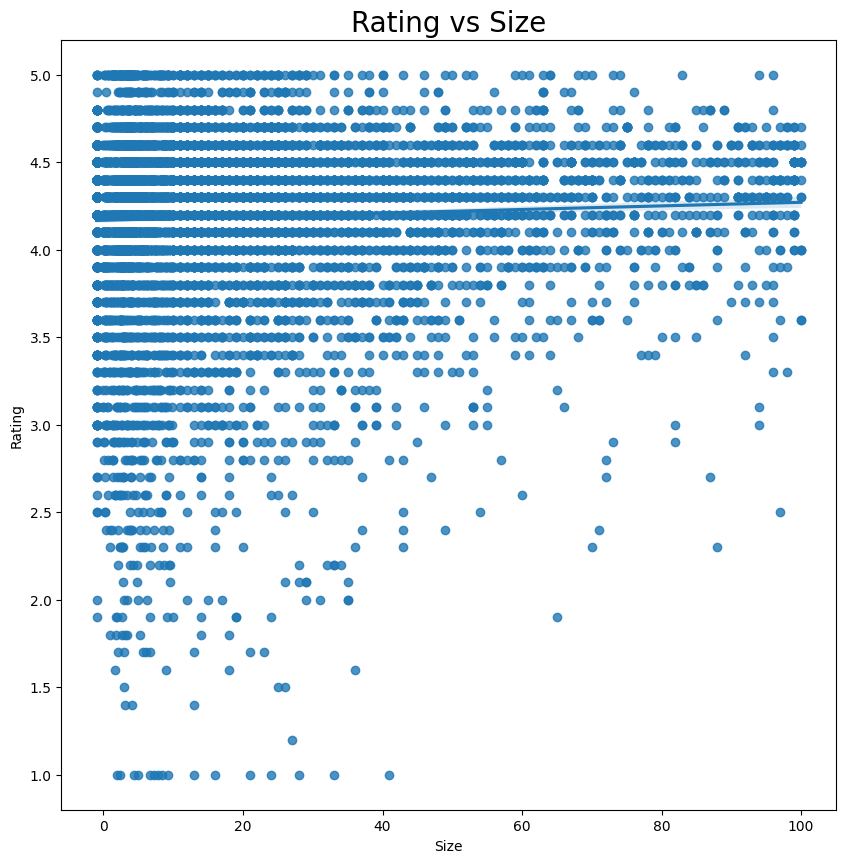

In [319]:
plt.figure(figsize = (10,10))
sns.regplot(x="Size", y="Rating", data=dataset)
plt.title('Rating vs Size',size = 20)

Veiem doncs, que també existeix una tendència en que com més pesa una aplicació més ben valorada està. Una hipòtesi podria ser que si pesa més, implica una aplicació treballada i de qualitat capaç d'assolir els seus objectius i satisfer les necessitats de l'usuari final.

Seguim amb la comparativa amb la columna "**Categories**", que té un munt de diferents categories. És per això que en farem un gràfic de caixes per veure-ho millor:

Text(0.5, 1.0, 'Rating vs Category')

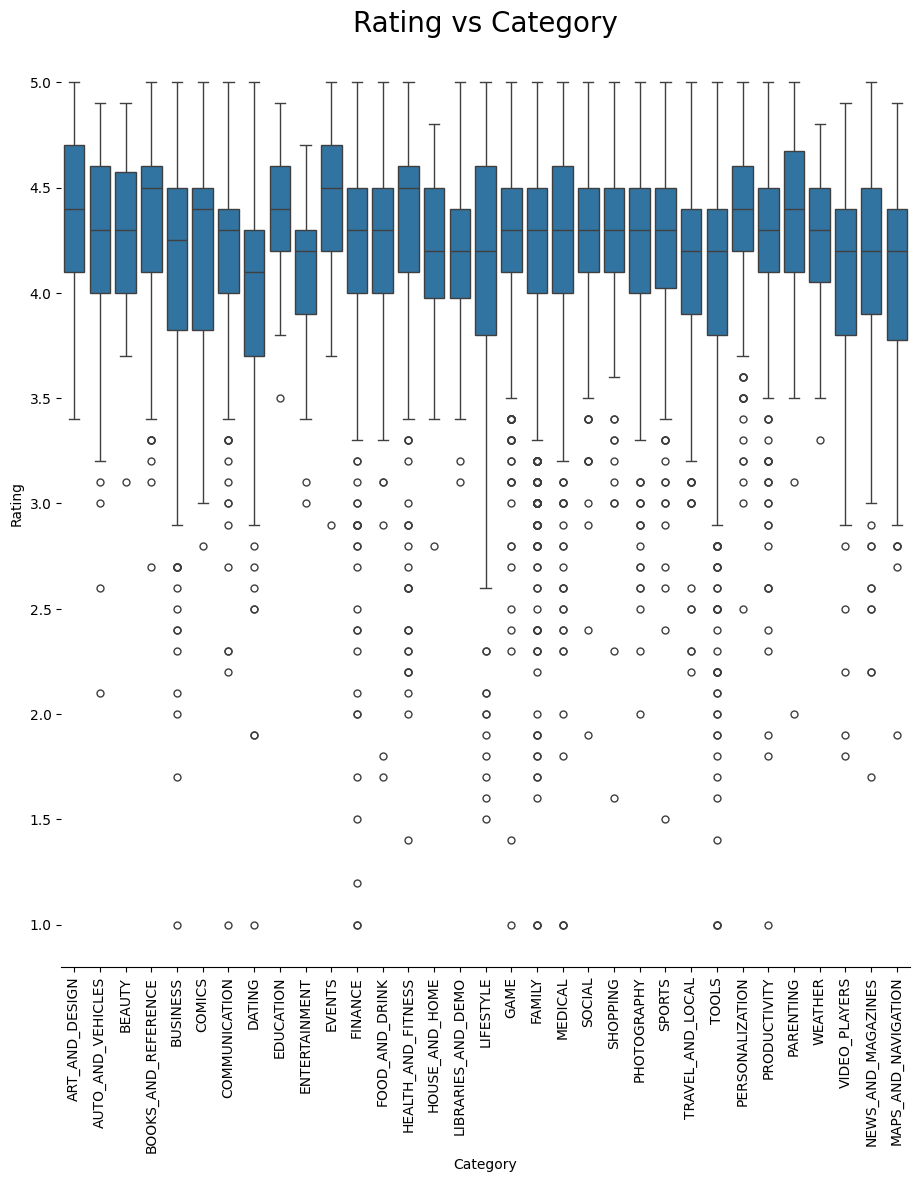

In [320]:
g = sns.catplot(x="Category",y="Rating",data=dataset, kind="box", height = 10)
g.set_xticklabels(rotation=90)
g.despine(left=True)
g = g.set_ylabels("Rating")
plt.title('Rating vs Category',size = 20)

En aquest cas veiem que les valoracions de les apps de diferents categories són generalment semblants i no podem concloure'n cap relació.

Seguidament provarem també de trobar alguna relació entre la valoració i la columna "**Installs**". Fem el mateix que amb les columnes anteriors i ho mostrem a través d'un jointplot:

<Figure size 1000x1000 with 0 Axes>

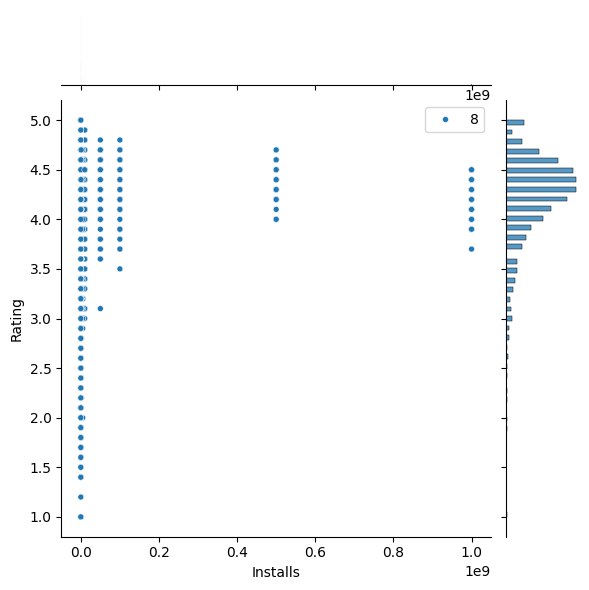

In [321]:
plt.figure(figsize = (10,10))
g = sns.jointplot(x="Installs", y="Rating", data=dataset, size = 8)

Observem una distribució que implica que pugui haver-hi una relació, tot i que és estranya. Tornem a veure'n la tendència per veure si existeix:

Text(0.5, 1.0, 'Rating vs Installs')

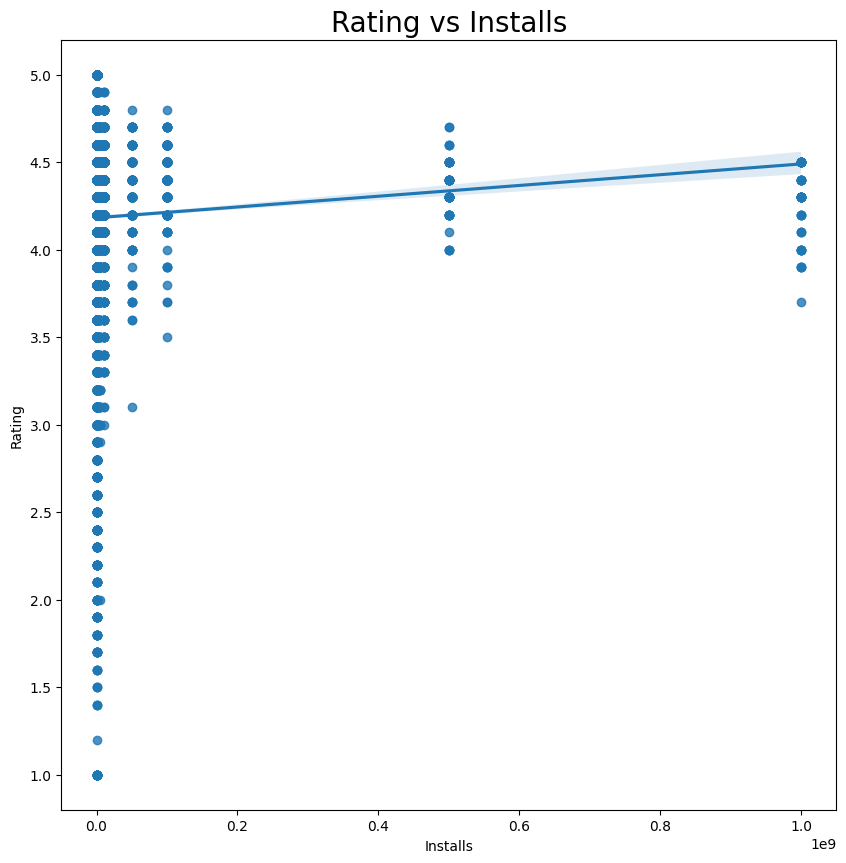

In [322]:
plt.figure(figsize = (10,10))
sns.regplot(x="Installs", y="Rating", data=dataset)
plt.title('Rating vs Installs',size = 20)

Doncs veiem que sí, que sembla que existeix una relació i una possible hipòtesi seria que com més cops es descarregui una app, més probable que els usuaris en deixin una review.

Seguidament, comparem amb la columna "**Price**", per veure si hi ha alguna relació entre el preu de l'aplicació i la seva valoració.

<Figure size 1000x1000 with 0 Axes>

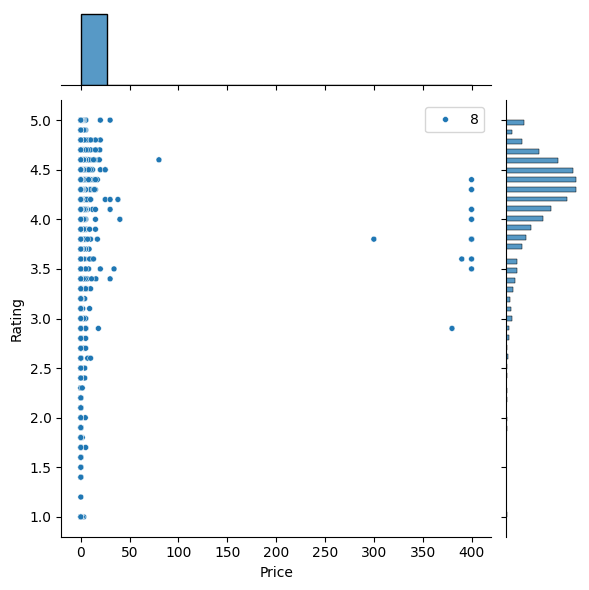

In [323]:
plt.figure(figsize = (10,10))
g = sns.jointplot(x="Price", y="Rating", data=dataset, size = 8)

Observem que les aplicacions més cares tenen bones valoracions, al voltant d'entre 3.5 i 5 estrelles, però que també existeix un gran nombre d'aplicacions gratuïtes o molt barates que també hi arriben. Mirem de fer una regressió per comprovar si existeix alguna tendència:

Text(0.5, 1.0, 'Rating vs Price')

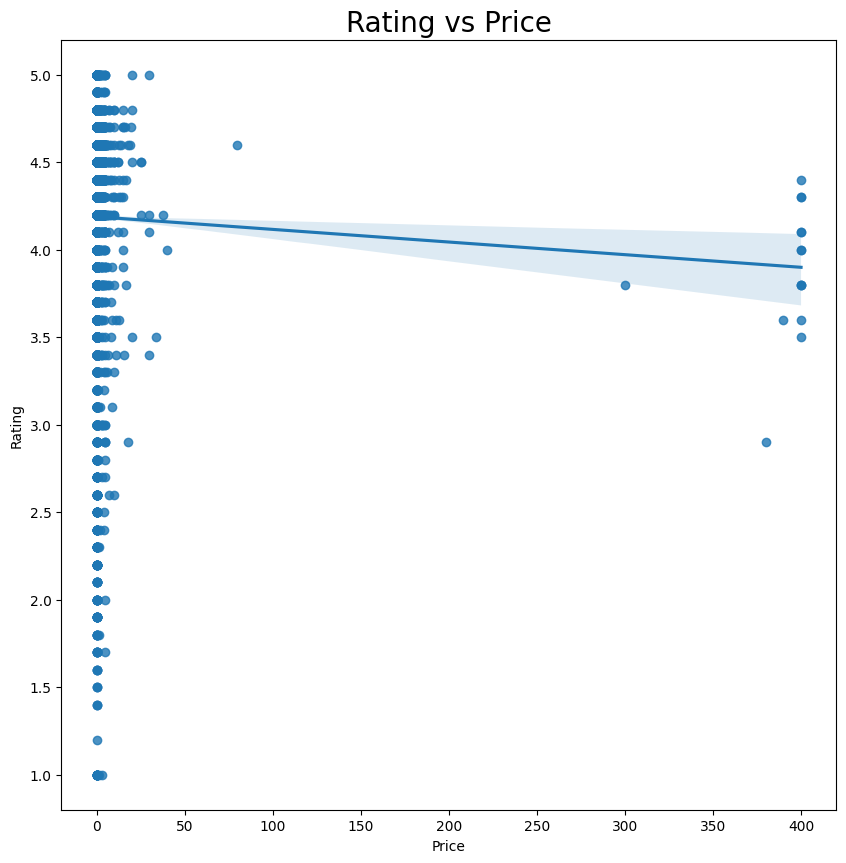

In [324]:
plt.figure(figsize = (10,10))
sns.regplot(x="Price", y="Rating", data=dataset)
plt.title('Rating vs Price',size = 20)

Però observem que no existeix cap tendència clara que permeti veure-hi una relació.

Seguim amb la columna "**Genres**" per estudiar si existeix cap relació entre el tipus de gènere d'aplicació i la seva valoració:

Text(0.5, 1.0, 'Rating vs Genres')

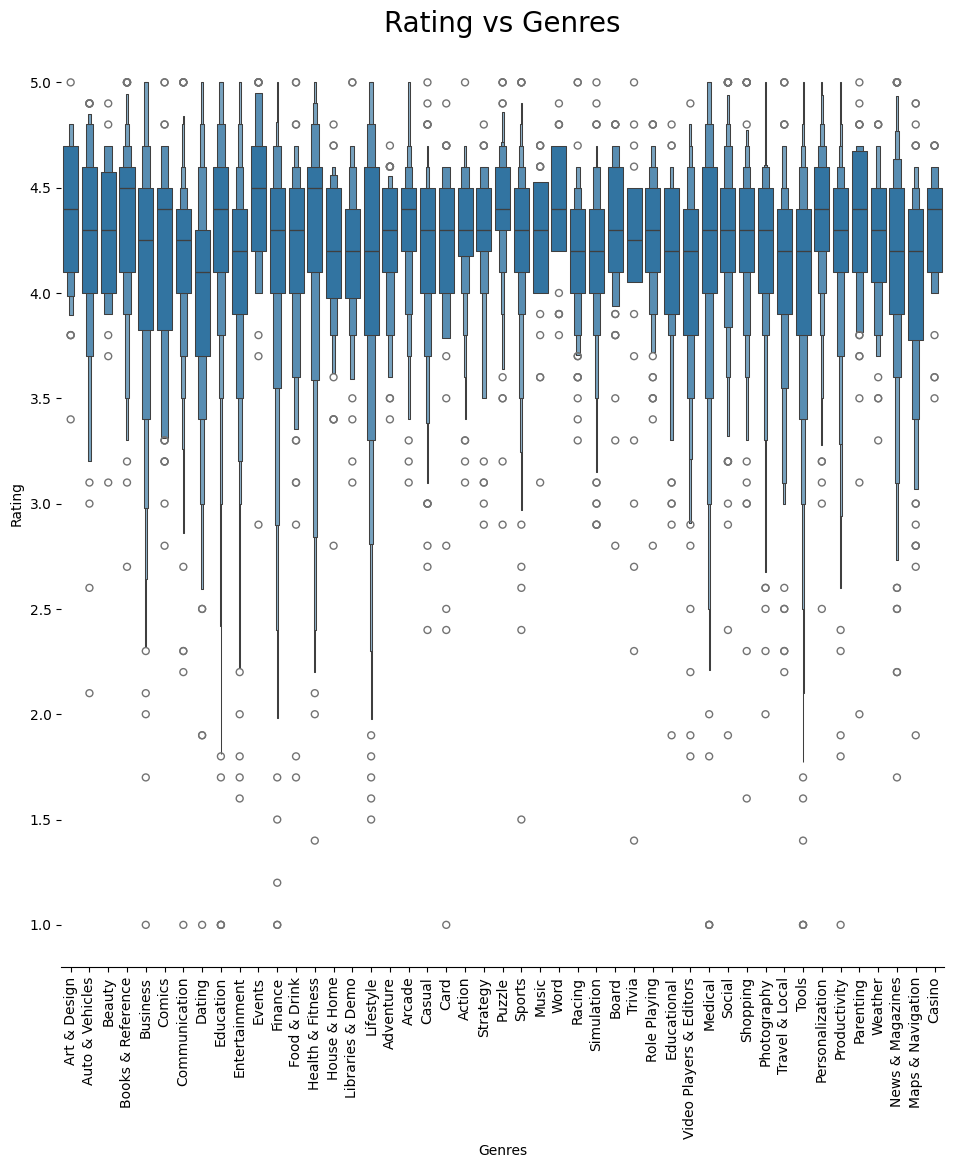

In [325]:
g = sns.catplot(x="Genres",y="Rating",data=dataset, kind="boxen", height = 10)
g.set_xticklabels(rotation=90)
g.despine(left=True)
g = g.set_ylabels("Rating")
plt.title('Rating vs Genres',size = 20)

Veient el gràfic de caixes, observem que no existeix cap relació entre els diferents gèneres i la valoració doncs tots tenen una tendència semblant.

Finalment, fem un estudi de la correlació entre "**Rating**" i "**Last Updated**" a veure si existeix una tendència en que com més actualitzacions constants rebi una app, millor valoracions té. Fem un jointplot per mostrar-ne la distribució:

<Figure size 1000x1000 with 0 Axes>

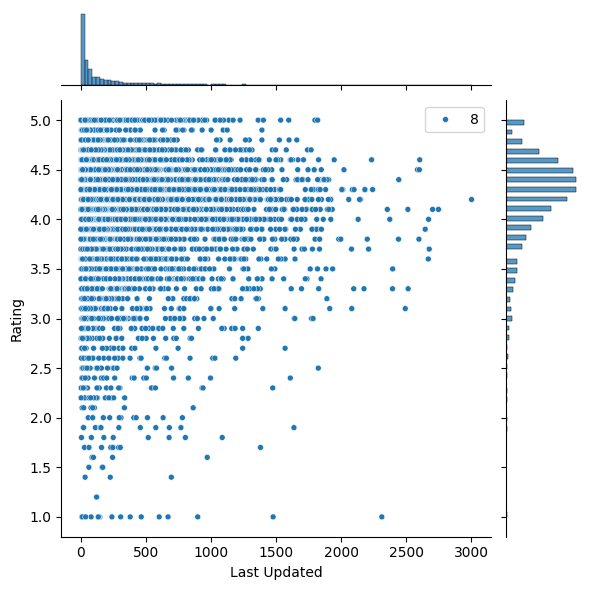

In [326]:
plt.figure(figsize = (10,10))
g = sns.jointplot(x="Last Updated", y="Rating", data=dataset, size = 8)

Mirem quina tendència de les dades existeix a través d'una regressió:

Text(0.5, 1.0, 'Rating vs Last Updated')

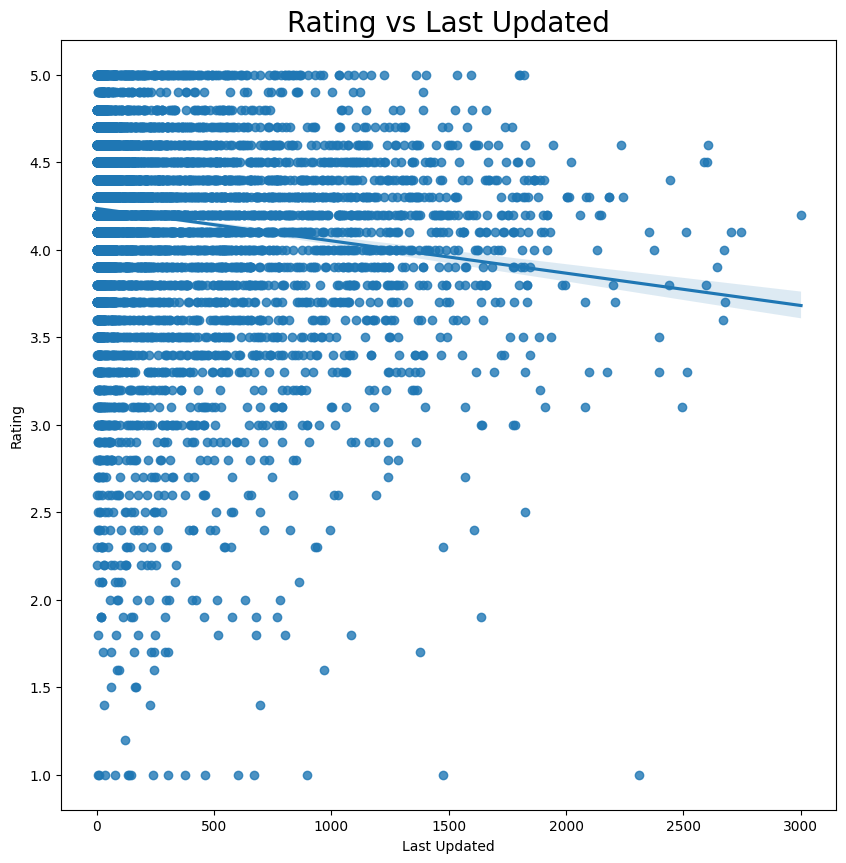

In [327]:
plt.figure(figsize = (10,10))
sns.regplot(x="Last Updated", y="Rating", data=dataset)
plt.title('Rating vs Last Updated',size = 20)

Observem que, com més actualitzada està una aplicació (menys dies respecte a la aplicació actualitzada més recentment), sol tenir una valoració més alta.

# Models

Entrenarem diferents models per tal de que prediguin la valoració d'una aplicació, que hem detectat que és el que més fa que es descarreguin.

Primer transformem les dades que no siguin valors numèrics a, valgui la redundància, a valors numèrics perquè els models els puguin interpretar correctament. Farem servir un label encoder

In [328]:
label_encoder=LabelEncoder()

dataset['App']=label_encoder.fit_transform(dataset['App'])
dataset['Category']=label_encoder.fit_transform(dataset['Category'])
dataset['Genres']=label_encoder.fit_transform(dataset['Genres'])
dataset['Content Rating']=label_encoder.fit_transform(dataset['Content Rating'])
dataset['Type']=label_encoder.fit_transform(dataset['Type'])

Eliminem les columnes que no farem servir per aplicar els models com "**Current Ver**", "**Android Ver**".

In [329]:
dataset.drop(['Current Ver', 'Android Ver'],axis=1,inplace=True)

Definim les variables per poder aplicar els models. L'objectiu a predir serà la nota de valoració de l'aplicació, que hem vist que era molt important a l'hora d'obtenir descàrregues.

In [330]:
X = dataset.drop(['Rating'],axis=1)
Y = dataset['Rating']
Y = Y.astype('int')

x_train,x_test,y_train,y_test = train_test_split( X, Y, test_size=0.25, random_state=1)

std_scale = StandardScaler()
x_train = std_scale.fit_transform(x_train)
x_test = std_scale.fit_transform(x_test)
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

## Regressió Lineal

In [331]:
linear_regression = LinearRegression()

linear_regression.fit(x_train, y_train)
r2_train=linear_regression.score(x_train, y_train)
r2_test=linear_regression.score(x_test, y_test)
print('R2 entrenament Regressió Lineal',r2_train)
print('R2 test Regressió Lineal',r2_test)

y_predict = linear_regression.predict(x_test)
mse=metrics.mean_squared_error(y_predict, y_test)

root_mse=np.sqrt(mse)
print('Error quadràtic mitjà:',root_mse)

R2 entrenament Regressió Lineal 0.021377832474045233
R2 test Regressió Lineal 0.020359845842257474
Error quadràtic mitjà: 0.5727428273417466


## Regressió Logística

In [332]:
logistic_regressor = LogisticRegression()

logistic_regressor.fit(x_train, y_train)
r2_train=logistic_regressor.score(x_train, y_train)
r2_test=logistic_regressor.score(x_test, y_test)
print('R2 entrenament Regressió Logística',r2_train)
print('R2 test Regressió Logística',r2_test)

y_predict = logistic_regressor.predict(x_test)
mse=metrics.mean_squared_error(y_predict, y_test)

root_mse=np.sqrt(mse)
print('Error quadràtic mitjà:',root_mse)

R2 entrenament Regressió Logística 0.7512766596575549
R2 test Regressió Logística 0.7450450450450451
Error quadràtic mitjà: 0.6238502938920436


c:\Users\Beri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Decision Tree

In [333]:
decision_tree_regressor = DecisionTreeRegressor(random_state=1)

decision_tree_regressor.fit(x_train, y_train)
r2_train=decision_tree_regressor.score(x_train, y_train)
r2_test=decision_tree_regressor.score(x_test, y_test)
print('R2 entrenament Decision Tree',r2_train)
print('R2 test Decision Tree',r2_test)

y_predict = decision_tree_regressor.predict(x_test)
mse=metrics.mean_squared_error(y_predict, y_test)

root_mse=np.sqrt(mse)
print('Error quadràtic mitjà:',root_mse)

R2 entrenament Decision Tree 1.0
R2 test Decision Tree -0.23895038672131585
Error quadràtic mitjà: 0.6441000425903299


## Random Forest

In [334]:
random_forest_regressor = RandomForestRegressor(n_estimators=100, random_state=1)

random_forest_regressor.fit(x_train, y_train)
r2_train=random_forest_regressor.score(x_train, y_train)
r2_test=random_forest_regressor.score(x_test, y_test)
print('R2 entrenament Random Forest',r2_train)
print('R2 test Random Forest',r2_test)

y_predict = random_forest_regressor.predict(x_test)
mse=metrics.mean_squared_error(y_predict, y_test)

root_mse=np.sqrt(mse)
print('Error quadràtic mitjà:',root_mse)

R2 entrenament Random Forest 0.8802078244129619
R2 test Random Forest -0.04300533847507482
Error quadràtic mitjà: 0.5909757163346878


## Màquina de Vectors de Suport

In [335]:
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(x_train, y_train)
r2_train=svm_classifier.score(x_train, y_train)
r2_test=svm_classifier.score(x_test, y_test)
print('R2 entrenament SVM',r2_train)
print('R2 test SVM',r2_test)

y_predict = svm_classifier.predict(x_test)
mse=metrics.mean_squared_error(y_predict, y_test)

root_mse=np.sqrt(mse)
print('Error quadràtic mitjà:',root_mse)

R2 entrenament SVM 0.7529288074496846
R2 test SVM 0.7432432432432432
Error quadràtic mitjà: 0.6252927242428069


Observem que els millors models, dels 4 executats són la Màquina de Vectors de Suport i la Regressió logística doncs són els que tenen els valors més grans.